In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from IPython.display import clear_output
clear_output()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

import torch
import os
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from transformers import  get_cosine_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.simplefilter("ignore", category=FutureWarning)
print('compelet')


compelet


In [4]:
# Load the dataset
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(418)

In [9]:
df.drop_duplicates(inplace=True)

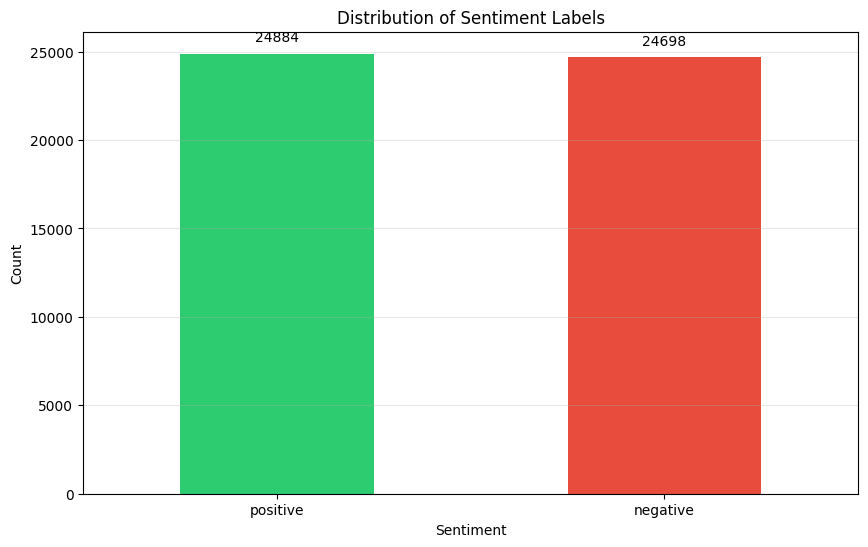

In [10]:
count_label = df['sentiment'].value_counts()

plt.figure(figsize=(10, 6))
bars = count_label.plot(kind='bar', color=['#2ecc71', '#e74c3c'] )
for i, v in enumerate(count_label):
    plt.text(i, v + 500, str(v), ha='center', va='bottom')


plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.show()

In [11]:
# Initialize  custom stopwords 
stop_words = set(stopwords.words('english'))

negatives = {
    "no", "not", "nor", "neither", "none", "never", "nobody", "nowhere", "nothing",
    "don't", "doesn't", "didn't", "won't", "wouldn't", "can't", "couldn't",
    "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't",
    "shouldn't", "mustn't", "mightn't", "needn't",'don', 'won', 'aren', 'couldn',
    'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'mightn', 'mustn', 'needn', 
    'shan', 'shouldn', 'wasn','weren', 'wouldn'}

custom_stop_words = stop_words - negatives

# lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|\#', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
   
    tokens = word_tokenize(text)
    # Remove  customs stopwords
    tokens = [word for word in tokens if word not in custom_stop_words ]
    text = ' '.join(tokens)
    
    return text

# Apply preprocessing
df['processed_text'] = df['review'].apply(preprocess_text)


C:\Users\Hareedy\AppData\Local\Temp\ipykernel_17904\1037759510.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


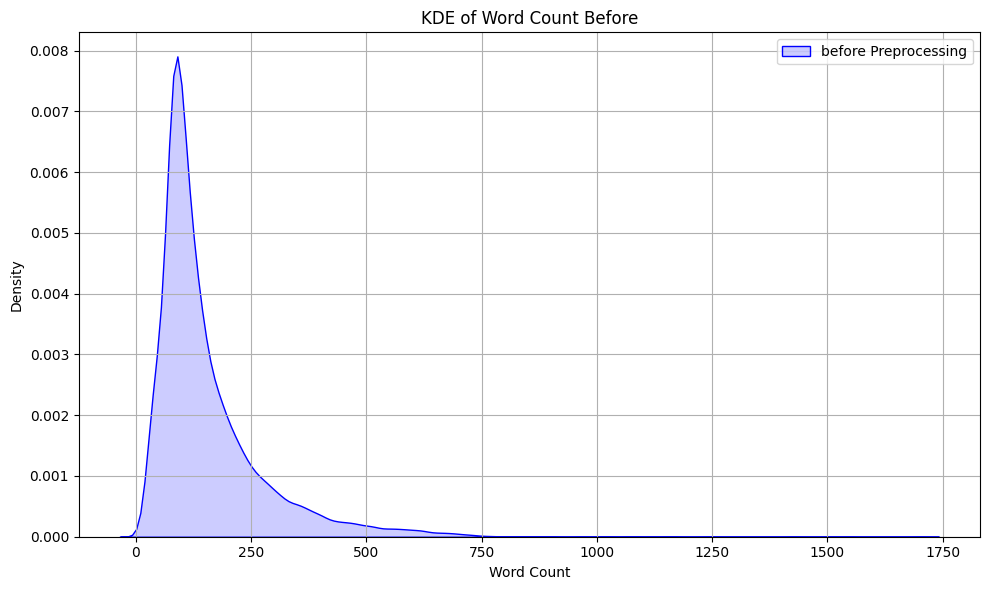

In [12]:
df['processed_length'] = df['processed_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.kdeplot(df['processed_length'], color='blue', label='before Preprocessing', fill=True, alpha=0.2)

plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title('KDE of Word Count Before')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
max_length = 512

valid_texts = []
valid_labels = []
long_texts = []
long_labels = []

for text, label in zip(df['processed_text'], df['sentiment']):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    if len(tokens) <= max_length:
        valid_texts.append(text)
        valid_labels.append(label)
    else:
        long_texts.append(text)
        long_labels.append(label)

df = pd.DataFrame({'processed_text': valid_texts, 'sentiment': valid_labels})

df_long = pd.DataFrame({'processed_text': long_texts, 'sentiment': long_labels})

df_long.to_csv("long_texts.csv", index=False)

print(f"valid reviews (≤ 512 tokens): {len(df)}")
print(f"long reviews (> 512 tokens): {len(df_long)}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\Hareedy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Hareedy\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


valid reviews (≤ 512 tokens): 47288
long reviews (> 512 tokens): 2294


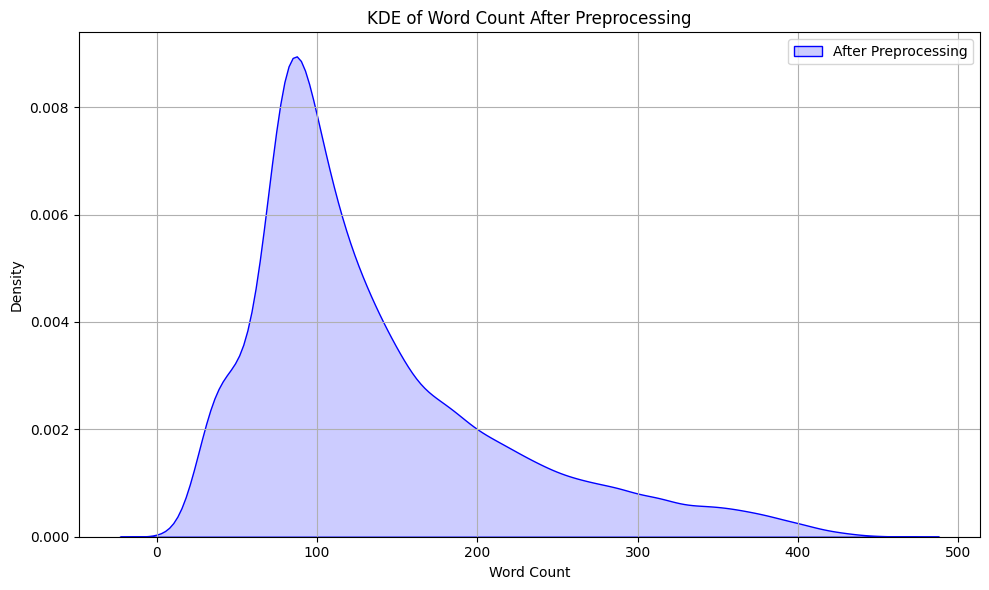

In [14]:
df['processed_length'] = df['processed_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.kdeplot(df['processed_length'], color='blue', label='After Preprocessing', fill=True, alpha=0.2)

plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title('KDE of Word Count After Preprocessing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


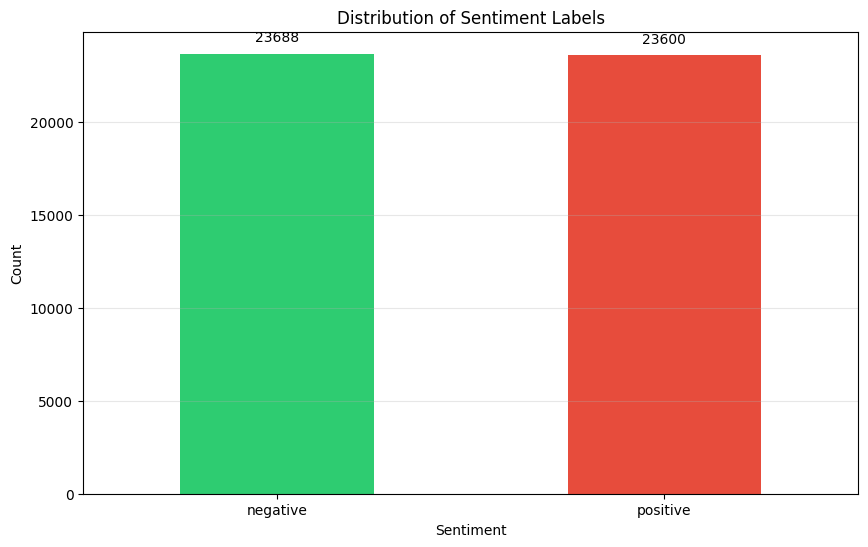

In [14]:
count_label = df['sentiment'].value_counts()

plt.figure(figsize=(10, 6))
bars = count_label.plot(kind='bar', color=['#2ecc71', '#e74c3c'] )
for i, v in enumerate(count_label):
    plt.text(i, v + 500, str(v), ha='center', va='bottom')


plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.show()

In [15]:
#Encoding label
from sklearn.preprocessing import LabelEncoder

# Fit label encoder
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])


In [16]:
# Split the data into train and temp(validation+test)
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    df['processed_text'], df['sentiment'], test_size=0.3, random_state=42, stratify=df['sentiment']
)
# Split the temp data into test and validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 33101
Validation set size: 9930
Test set size: 4257


In [17]:
#pip install torch transformers

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
from transformers import RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification

model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
config = RobertaConfig.from_pretrained(
    model_name,
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3,
    output_attentions=False,
    output_hidden_states=False,
)

model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.to(device)


def tokenize_data(texts, labels, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values, dtype=torch.long)
    
    return input_ids, attention_masks, labels

train_inputs, train_masks, train_labels = tokenize_data(X_train, y_train, tokenizer)
val_inputs, val_masks, val_labels = tokenize_data(X_val, y_val, tokenizer)
test_inputs, test_masks, test_labels = tokenize_data(X_test, y_test, tokenizer)

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


Using device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
#  Optimizer , Scheduler
epochs = 50
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=0.01)
total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, total_steps)

# Training Function with Early Stopping
def train_model(model, train_dataloader, val_dataloader, epochs, optimizer, scheduler, device, save_path="best_model.pt"):
    best_val_acc = 0
    training_stats = []
    best_weights = None
    early_stop_patience = 5
    epochs_no_improve = 0
    early_stopped = False

    for epoch in range(epochs):
        print(f"\n Epoch {epoch + 1} / {epochs} ===")

        model.train()
        total_train_loss = 0
        train_preds = []
        train_labels = []

        for batch in tqdm(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            outputs = model(
                b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

            loss = outputs.loss
            logits = outputs.logits
            total_train_loss += loss.item()

            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = b_labels.detach().cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = accuracy_score(train_labels, train_preds)

        # Validation
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(val_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels
                )

            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = b_labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = accuracy_score(all_labels, all_preds)

        print(f"Epoch {epoch+1:02} | Train Acc: {train_accuracy:.4f} | Train Loss: {avg_train_loss:.4f} |  Val Acc: {val_accuracy:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early Stopping
        if val_accuracy > best_val_acc:
            print(f"New best val_accuracy: {val_accuracy:.4f} (improved from {best_val_acc:.4f})")
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            torch.save(best_weights, save_path)
            print(f"Best model saved to {save_path}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement in val_accuracy. ({epochs_no_improve}/{early_stop_patience})")
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping triggered after {early_stop_patience} epochs without improvement.")
                early_stopped = True
                break

        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        })

    if early_stopped:
        print("Training was stopped early due to no improvement in validation loss.")

    return training_stats

training_stats = train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device
)



 Epoch 1 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.37it/s]


Epoch 01 | Train Acc: 0.5629 | Train Loss: 0.6591 |  Val Acc: 0.8497 | Val Loss: 0.3931
New best val_accuracy: 0.8497 (improved from 0.0000)
Best model saved to best_model.pt

 Epoch 2 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.38it/s]


Epoch 02 | Train Acc: 0.8318 | Train Loss: 0.3819 |  Val Acc: 0.8890 | Val Loss: 0.2911
New best val_accuracy: 0.8890 (improved from 0.8497)
Best model saved to best_model.pt

 Epoch 3 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.32it/s]


Epoch 03 | Train Acc: 0.8618 | Train Loss: 0.3271 |  Val Acc: 0.8930 | Val Loss: 0.2594
New best val_accuracy: 0.8930 (improved from 0.8890)
Best model saved to best_model.pt

 Epoch 4 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.35it/s]


Epoch 04 | Train Acc: 0.8745 | Train Loss: 0.2972 |  Val Acc: 0.9038 | Val Loss: 0.2955
New best val_accuracy: 0.9038 (improved from 0.8930)
Best model saved to best_model.pt

 Epoch 5 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.37it/s]


Epoch 05 | Train Acc: 0.8846 | Train Loss: 0.2810 |  Val Acc: 0.9021 | Val Loss: 0.2693
No improvement in val_accuracy. (1/5)

 Epoch 6 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.38it/s]


Epoch 06 | Train Acc: 0.8939 | Train Loss: 0.2609 |  Val Acc: 0.9140 | Val Loss: 0.2331
New best val_accuracy: 0.9140 (improved from 0.9038)
Best model saved to best_model.pt

 Epoch 7 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.38it/s]


Epoch 07 | Train Acc: 0.9010 | Train Loss: 0.2451 |  Val Acc: 0.9153 | Val Loss: 0.2495
New best val_accuracy: 0.9153 (improved from 0.9140)
Best model saved to best_model.pt

 Epoch 8 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.39it/s]


Epoch 08 | Train Acc: 0.9074 | Train Loss: 0.2307 |  Val Acc: 0.9155 | Val Loss: 0.2624
New best val_accuracy: 0.9155 (improved from 0.9153)
Best model saved to best_model.pt

 Epoch 9 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.37it/s]


Epoch 09 | Train Acc: 0.9138 | Train Loss: 0.2183 |  Val Acc: 0.9098 | Val Loss: 0.2636
No improvement in val_accuracy. (1/5)

 Epoch 10 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.39it/s]


Epoch 10 | Train Acc: 0.9186 | Train Loss: 0.2075 |  Val Acc: 0.9199 | Val Loss: 0.2379
New best val_accuracy: 0.9199 (improved from 0.9155)
Best model saved to best_model.pt

 Epoch 11 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.35it/s]


Epoch 11 | Train Acc: 0.9240 | Train Loss: 0.1977 |  Val Acc: 0.9218 | Val Loss: 0.2616
New best val_accuracy: 0.9218 (improved from 0.9199)
Best model saved to best_model.pt

 Epoch 12 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.38it/s]


Epoch 12 | Train Acc: 0.9238 | Train Loss: 0.1934 |  Val Acc: 0.9206 | Val Loss: 0.2423
No improvement in val_accuracy. (1/5)

 Epoch 13 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.37it/s]


Epoch 13 | Train Acc: 0.9328 | Train Loss: 0.1794 |  Val Acc: 0.9199 | Val Loss: 0.3074
No improvement in val_accuracy. (2/5)

 Epoch 14 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.39it/s]


Epoch 14 | Train Acc: 0.9356 | Train Loss: 0.1712 |  Val Acc: 0.9177 | Val Loss: 0.2844
No improvement in val_accuracy. (3/5)

 Epoch 15 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.37it/s]


Epoch 15 | Train Acc: 0.9382 | Train Loss: 0.1654 |  Val Acc: 0.9205 | Val Loss: 0.2502
No improvement in val_accuracy. (4/5)

 Epoch 16 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.39it/s]


Epoch 16 | Train Acc: 0.9445 | Train Loss: 0.1543 |  Val Acc: 0.9229 | Val Loss: 0.2712
New best val_accuracy: 0.9229 (improved from 0.9218)
Best model saved to best_model.pt

 Epoch 17 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.39it/s]


Epoch 17 | Train Acc: 0.9453 | Train Loss: 0.1496 |  Val Acc: 0.9199 | Val Loss: 0.2870
No improvement in val_accuracy. (1/5)

 Epoch 18 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.38it/s]


Epoch 18 | Train Acc: 0.9489 | Train Loss: 0.1432 |  Val Acc: 0.9219 | Val Loss: 0.3231
No improvement in val_accuracy. (2/5)

 Epoch 19 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.34it/s]


Epoch 19 | Train Acc: 0.9524 | Train Loss: 0.1349 |  Val Acc: 0.9211 | Val Loss: 0.2908
No improvement in val_accuracy. (3/5)

 Epoch 20 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.38it/s]


Epoch 20 | Train Acc: 0.9547 | Train Loss: 0.1283 |  Val Acc: 0.9189 | Val Loss: 0.3144
No improvement in val_accuracy. (4/5)

 Epoch 21 / 50 ===


100%|██████████| 311/311 [00:33<00:00,  9.37it/s]

Epoch 21 | Train Acc: 0.9565 | Train Loss: 0.1257 |  Val Acc: 0.9222 | Val Loss: 0.3447
No improvement in val_accuracy. (5/5)
Early stopping triggered after 5 epochs without improvement.
Training was stopped early due to no improvement in validation loss.


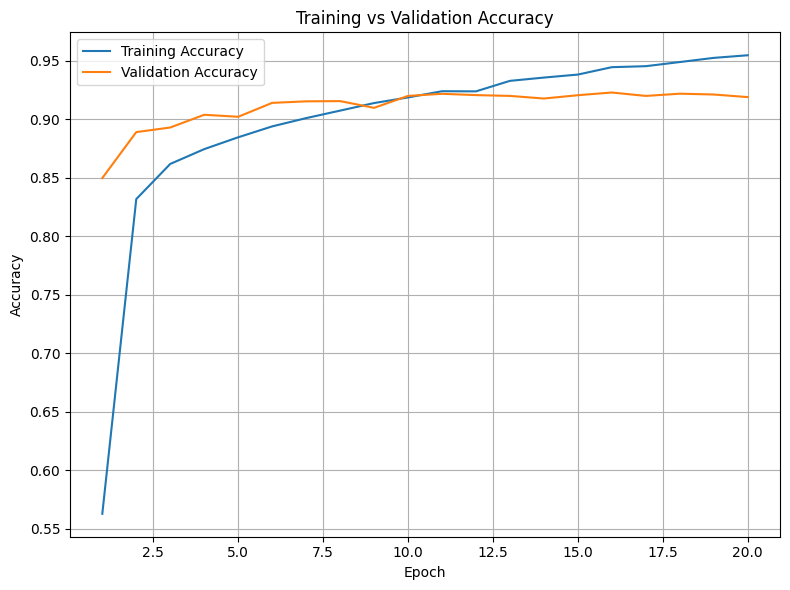

In [20]:
# Plot Training & Validation Accuracy
import matplotlib.pyplot as plt

train_acc = [stat['train_accuracy'] for stat in training_stats]
val_acc = [stat['val_accuracy'] for stat in training_stats]
epochs_range = [stat['epoch'] for stat in training_stats]

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


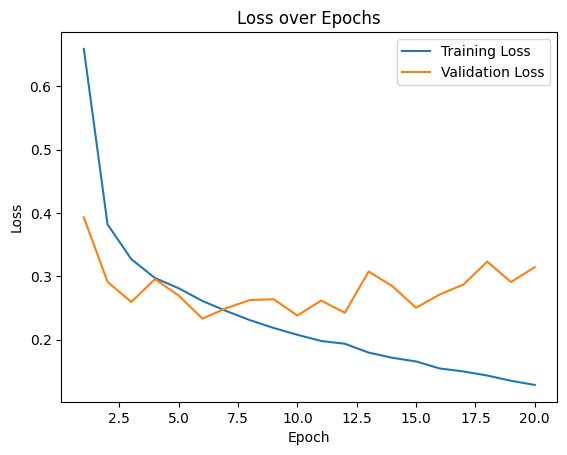

In [21]:
# Example: Plotting training and validation loss
import matplotlib.pyplot as plt

train_loss = [stat['train_loss'] for stat in training_stats]
val_loss = [stat['val_loss'] for stat in training_stats]
epochs_range = [stat['epoch'] for stat in training_stats]

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


In [ ]:

def evaluate_test_set(model, test_dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in tqdm(test_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = b_labels.detach().cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    print("\nClassification Report:")
    print(report)

    print("Confusion Matrix:")
    print(cm)
    

    return accuracy, precision, recall, f1 ,all_labels ,all_preds


acc ,precision ,recall ,f1 ,labels ,preds=  evaluate_test_set(model, test_dataloader, device)


accuracy on test : 93.27

Classification Report:
              precision    recall  f1-score   support

           0     0.9271    0.9405    0.9338      2137
           1     0.9386    0.9245    0.9315      2120

    accuracy                         0.9327      4257
   macro avg     0.9328    0.9325    0.9326      4257
weighted avg     0.9328    0.9327    0.9326      4257

Confusion Matrix:
[[2009  128]
 [ 160 1960]]


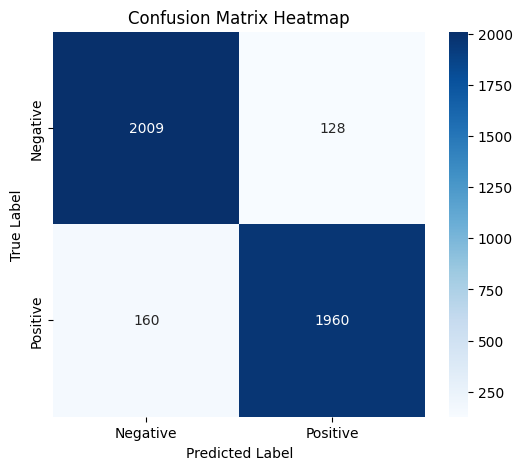

In [ ]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative',  'Positive'],
            yticklabels=['Negative',  'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.savefig("confusion_matrix_heatmap.png")
plt.show()

In [23]:
def predict_sentiment(text, model, tokenizer, device):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Tokenize
    encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
    
    # Move to device
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get prediction class
    prediction = torch.argmax(logits, dim=1).item()
    
    # Map prediction to sentiment
    sentiment_map = {0: 'Negative', 1: 'positive'}
    sentiment = sentiment_map[prediction]
    
    return sentiment

# Example usage
sample_texts = [
    "I absolutely love this product! It's amazing!",
    "This is the worst experience I've ever had."
]

for text in sample_texts:
    sentiment = predict_sentiment(text, model, tokenizer, device)
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment}\n")

Text: I absolutely love this product! It's amazing!
Sentiment: positive

Text: This is the worst experience I've ever had.
Sentiment: Negative

